In [1]:
import rioxarray
import os
import glob

# 打印指定路径下的所有数据结构
data_path = r'D:\xarray\pre-process'

# 列出目录中的所有文件和文件夹
print("Files and directories in", data_path, ":")
for item in os.listdir(data_path):
    item_path = os.path.join(data_path, item)
    if os.path.isdir(item_path):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")

# 列出所有GeoTIFF文件
geotiff_files = glob.glob(os.path.join(data_path, "*.tif"))
print("\nGeoTIFF files found:")
for file in geotiff_files:
    print(f"- {os.path.basename(file)}")

# 如果有GeoTIFF文件，加载第一个并显示其结构
if geotiff_files:
    print("\nLoading first GeoTIFF file for structure analysis...")
    da = rioxarray.open_rasterio(geotiff_files[0])
    
    # 打印概览
    print("\nData overview:")
    print(da)
    
    # 查看维度、坐标
    print("\nDimensions:", da.dims)
    print("Coordinates:", da.coords)
    
    # 查看元数据
    print("\nMetadata:")
    print("CRS:", da.rio.crs)
    print("Transform:", da.rio.transform())
    print("NoData value:", da.rio.nodata)
    print("Attributes:", da.attrs)
else:
    print("\nNo GeoTIFF files found in the directory.")


Files and directories in D:\xarray\pre-process :
File: Global_elevation_1KMmn_GMTEDmn.tif
File: Global_rast_adm2_gdp_perCapita_1990_2022.tif
File: Global_rast_gdpTot_1990_2020_30arcsec.tif
File: Global_slope_1KMmn_GMTEDmd.tif
File: gpw_v4_population_density_rev11_2000_30_sec.tif
File: gpw_v4_population_density_rev11_2005_30_sec.tif
File: gpw_v4_population_density_rev11_2015_30_sec.tif
File: gpw_v4_population_density_rev11_2020_30_sec.tif
Directory: Population_1995_2020

GeoTIFF files found:
- Global_elevation_1KMmn_GMTEDmn.tif
- Global_rast_adm2_gdp_perCapita_1990_2022.tif
- Global_rast_gdpTot_1990_2020_30arcsec.tif
- Global_slope_1KMmn_GMTEDmd.tif
- gpw_v4_population_density_rev11_2000_30_sec.tif
- gpw_v4_population_density_rev11_2005_30_sec.tif
- gpw_v4_population_density_rev11_2015_30_sec.tif
- gpw_v4_population_density_rev11_2020_30_sec.tif

Loading first GeoTIFF file for structure analysis...

Data overview:
<xarray.DataArray (band: 1, y: 16800, x: 43200)> Size: 3GB
[725760000 val

In [11]:
import xarray as xr
ds=xr.open_dataset(r'D:\xarray\final_mask_1km_new.nc')

population=xr.open_dataset(r'D:\xarray\population_density_simple.nc')

ds['final_mask'].values[0,0]



nan

In [ ]:
lat_resolution=ds.lat.values[1]-ds.lat.values[0]
lon_resolution=ds.lon.values[1]-ds.lon.values[0]
print(lat_resolution,lon_resolution)

p_lat_resolution=population.lat.values[1]-population.lat.values[0]
p_lon_resolution=population.lon.values[1]-population.lon.values[0]
print(p_lat_resolution,p_lon_resolution)





-0.008333333333354176 0.008333333333325754
-0.008333333333339965 0.008333333333325754


<xarray.DataArray (lat: 525, lon: 1910)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 15kB -180.0 -180.0 -180.0 ... -128.1 -128.0 -128.0
  * lat      (lat) float64 4kB -58.12 -58.25 -58.37 ... -89.93 -89.94 -90.0
    time     datetime64[ns] 8B ...

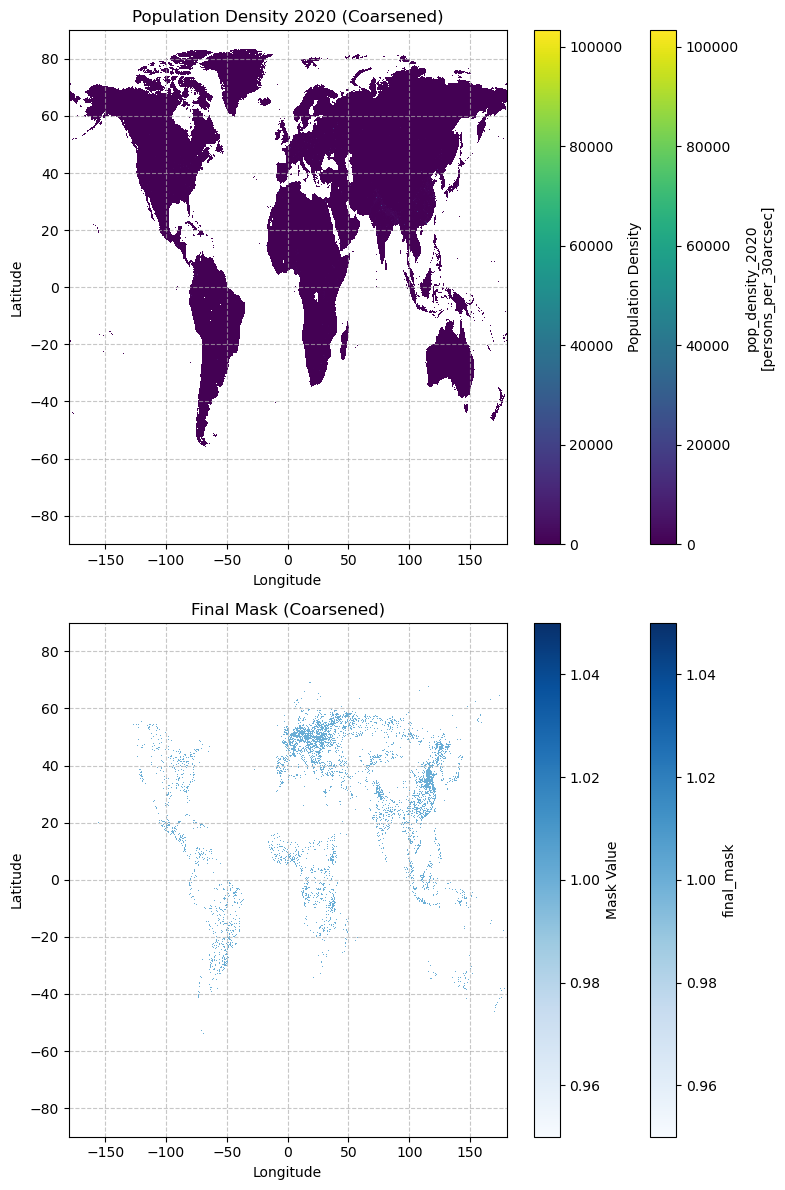

In [3]:
# Plot the result with coarsening to improve visualization
import matplotlib.pyplot as plt

# Define coarsening factor
coarsen_factor = 5  # Adjust this value based on your data resolution

# Coarsen the data for better visualization
pop_coarse = population['pop_density_2020'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()
mask_coarse = ds['final_mask'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()

# Create a vertical layout (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Plot coarsened population density
pop_map = pop_coarse.plot(ax=axes[0], cmap='viridis')
axes[0].set_title('Population Density 2020 (Coarsened)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(pop_map, ax=axes[0], label='Population Density')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot coarsened final mask
mask_map = mask_coarse.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Final Mask (Coarsened)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(mask_map, ax=axes[1], label='Mask Value')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
# Calculate the valid data in 'ds'
import numpy as np

valid_count = (~np.isnan(ds['final_mask'])).sum().item()
total_count = ds['final_mask'].size
valid_percentage = (valid_count / total_count) * 100

print(f"Valid data points in final_mask: {valid_count:,} out of {total_count:,} total points")
print(f"Percentage of valid data: {valid_percentage:.2f}%")


Valid data points in final_mask: 2,164,411 out of 933,120,000 total points
Percentage of valid data: 0.23%


In [1]:
import datetime as dt
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig, CatalogueEnvironment

# Create a link to the CLMS catalogue
config = CatalogueConfig.from_environment(CatalogueEnvironment.CGLS)
catalogue = Catalogue(config)

# Optionally list all collections (title and identifier) available in the catalogue
for c in list(catalogue.get_collections()):  
    print(f"{c.properties.get('title')} | {c.id}")

Burnt Area: global daily (raster 300m) | clms_global_ba_300m_v3_daily_geotiff
Burnt Area: global daily (raster 300m) | clms_global_ba_300m_v3_daily_netcdf
Burnt Area: global monthly (raster 300m) | clms_global_ba_300m_v3_monthly_geotiff
Burnt Area: global monthly (raster 300m) | clms_global_ba_300m_v3_monthly_netcdf
Dry Matter Productivity: global 10-daily (raster 1km) | clms_global_dmp_1km_v2_10daily_geotiff
Dry Matter Productivity: global 10-daily (raster 1km) | clms_global_dmp_1km_v2_10daily_netcdf
Dry Matter Productivity: global 10-daily (raster 300m) | clms_global_dmp_300m_v1_10daily_geotiff
Dry Matter Productivity: global 10-daily (raster 300m) | clms_global_dmp_300m_v1_10daily_netcdf
Fraction of Absorbed Photosynthetically Active Radiation: global 10-daily (raster 1km) | clms_global_fapar_1km_v1_10daily_geotiff
Fraction of Absorbed Photosynthetically Active Radiation: global 10-daily (raster 1km) | clms_global_fapar_1km_v1_10daily_netcdf
Fraction of Absorbed Photosynthetically A

In [3]:
import datetime as dt
import os
from tqdm import tqdm

# 你要下载的产品ID
product_id = "clms_global_gdmp_1km_v2_10daily_netcdf"

# 四季代表日期
season_days = {
    "spring": (3, 21),
    "summer": (6, 21),
    "autumn": (9, 23),
    "winter": (12, 21)
}

# 下载根目录
base_dir = r"pre-process\Gross_productivity"  # 修改为你想保存的根目录
os.makedirs(base_dir, exist_ok=True)

# 创建年份和季节的组合列表用于进度条
total_items = len(range(2000, 2023)) * len(season_days)
progress_bar = tqdm(total=total_items, desc="Downloading data")

for year in range(2000, 2023):
    for season, (month, day) in season_days.items():
        try:
            date = dt.date(year, month, day)
            products = list(catalogue.get_products(
                product_id,
                start=date,
                end=date
            ))
            if products:
                # 直接下载到base_dir并重命名
                for product in products:
                    catalogue.download_product(product, base_dir)
                    print(f"Saved")
            else:
                print(f"No products found for {year} {season}")
        except Exception as e:
            print(f"Error for {year}-{season}: {e}")
        
        progress_bar.update(1)

progress_bar.close()

Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved
Saved
Saved
Saved


Saved


Saved
No products found for 2020 autumn


No products found for 2020 winter
No products found for 2021 spring


No products found for 2021 summer
No products found for 2021 autumn


No products found for 2021 winter
No products found for 2022 spring


No products found for 2022 summer
No products found for 2022 autumn


No products found for 2022 winter


Product information:


   Product title: "Soil Water Index - Static Layers (raster 12.5 km), global, 10-daily – version 3"
   UID: "93502460f78d4766af9f3a0399d8e78f"
   Product link: https://land.copernicus.eu/api/en/products/soil-moisture/soil-water-index-static-layers-v3-0-12-5-km


Download option for "Soil Water Index - Static Layers (raster 12.5 km), global, 10-daily – version 3":


{'@id': '1577b614-2a1a-44aa-b207-27c5d979a59c',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Water and Ice Cover 2025-present (raster 20 m, 60 m), Europe, daily"
   UID: "d045aba91c174cfba7c280392df745f1"
   Product link: https://land.copernicus.eu/api/en/products/water-bodies/water-and-ice-cover-raster-20-m-60-m-europe-daily


Download option for "Water and Ice Cover 2025-present (raster 20 m, 60 m), Europe, daily":


{'@id': '56773bd2-10cd-45d3-ab40-7ea9aa613f6e',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Lake Ice Extent 2024-present (raster 250 m), Europe, daily – version  2"
   UID: "3ee460dfc0eb48b09a3283bdcb913a50"
   Product link: https://land.copernicus.eu/api/en/products/water-bodies/lake-ice-extent-europe-v2-250m


Download option for "Lake Ice Extent 2024-present (raster 250 m), Europe, daily – version  2":


{'@id': '3e5bfdc3-241c-4feb-a9bc-46772ff44204',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Very High Resolution Image Mosaic 2021 True Colour (raster 2 m), Europe"
   UID: "c0b301ebe1fa40da8117ca6f13240baa"
   Product link: https://land.copernicus.eu/api/en/products/european-image-mosaic/very-high-resolution-image-mosaic-2021-true-colour-2m


Download option for "Very High Resolution Image Mosaic 2021 True Colour (raster 2 m), Europe":


{'@id': 'bc3d0068-198d-41de-820b-f3bf8c165354',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Lake Water Quality 2024-present (raster 300 m), global, 10-daily – version 2"
   UID: "9e8be500204945a48ce15fc8d1c57482"
   Product link: https://land.copernicus.eu/api/en/products/water-bodies/lake-water-quality-near-real-time-v2-0-300m


Download option for "Lake Water Quality 2024-present (raster 300 m), global, 10-daily – version 2":


{'@id': '837e6e7e-379d-437a-a715-0660e914a473',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "European Ground Motion Service Basic 2019-2023 (vector), Europe, yearly"
   UID: "00f7264e92d54a70b02bce9b315d7b32"
   Product link: https://land.copernicus.eu/api/en/products/european-ground-motion-service/egms-basic


Download option for "European Ground Motion Service Basic 2019-2023 (vector), Europe, yearly":


{'@id': '71e57b6f-a3f6-4a06-8dcc-5f71d90e235a',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "CLCplus Backbone 2021 (raster 10 m), Europe, 3-yearly"
   UID: "4d0d78ad472c45819aff1d9fa7af0461"
   Product link: https://land.copernicus.eu/api/en/products/clc-backbone/clc-backbone-2021


Download option for "CLCplus Backbone 2021 (raster 10 m), Europe, 3-yearly":


{'@id': 'b813d203-d09b-4663-95f7-65dc6d53789e',
 'area': 'Europe',
 'file': 'CLMS_CLCplus_RASTER_2021',
 'format': 'Geotiff',
 'path': 'H:\\Corine_Land_Cover_Backbone\\Corine_Land_Cover_Backbone_CLCBB_2021\\CLC_BB_2021\\Data\\data-details\\raster\\CLMS_CLCplus_RASTER_2021.zip',
 'resolution': '10 m',
 'size': '7 GB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'V1_1',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Burnt Area 2023 - present (raster 300 m), global, daily – version 3.1"
   UID: "6897d6fbb6a948f2819a836fe2341f48"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/burnt-area-v3-1-daily-300m


Download option for "Burnt Area 2023 - present (raster 300 m), global, daily – version 3.1":


{'@id': 'dab1166d-9cc9-48c2-9f0c-157a65a78f80',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "CLCplus Backbone 2018 (raster 10 m), Europe, 3-yearly"
   UID: "1c3f3e078a844661bbe23db99bdc8e2c"
   Product link: https://land.copernicus.eu/api/en/products/clc-backbone/clc-backbone-2018


Download option for "CLCplus Backbone 2018 (raster 10 m), Europe, 3-yearly":


{'@id': 'c3290e93-1463-4bed-93c9-6315b0059048',
 'area': 'Europe',
 'file': 'CLMS_CLCplus_RASTER_2018_010m_eu_03035_V1_1',
 'format': 'Geotiff',
 'path': 'H:\\Corine_Land_Cover_Backbone\\Corine_Land_Cover_Backbone_CLCBB_2018\\CLC_BB_2018\\Data\\data-details\\raster\\CLMS_CLCplus_RASTER_2018_010m_eu_03035_V1_1.zip',
 'resolution': '10 m',
 'size': '9 GB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'V1_1',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Season Maximum Value 2023-present (raster 300 m), global, yearly, version 1"
   UID: "28a93a5edcce4b6a931dc53b1c3f1eab"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/season-maximum-value-2023-raster-300m-global-yearly-version-1


Download option for "Season Maximum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '7c40815c-3fa8-4a09-bea1-a2142d6a9a31',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-MAXV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-MAXV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Maximum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'cccdd6b5-cce2-4eb5-9b0d-dd543b077e3e',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-MAXV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-MAXV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '110 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Maximum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '4149ee3c-d05b-4842-abe8-04ce9c6f9f0d',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-MAXV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-MAXV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Season Maximum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'eaab36e9-8a0c-4efc-9f27-0d94e138f367',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-MAXV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-MAXV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '172 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Slope of the Green-up Period 2023-present (raster 300 m), global, yearly, version 1"
   UID: "832db625b44e46af8da33ead4525ae64"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/slope_of_green-up-period-2023-raster-300m-global-yearly-version-1


Download option for "Slope of the Green-up Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '39b7e7bc-228d-4520-8268-bab19072b852',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-LSLOPE-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-LSLOPE-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Slope of the Green-up Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '67555468-dc55-43e6-8c56-e7e39bd2646d',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-LSLOPE-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-LSLOPE-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '80 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Slope of the Green-up Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '9abbbfd6-92cb-4966-bd8c-12b213a138cb',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-LSLOPE-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-LSLOPE-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Slope of the Green-up Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'c9a6a230-3915-4f4c-a69d-cfb0b3088c95',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-LSLOPE-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-LSLOPE-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '122 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Slope of the Green-down Period 2023-present (raster 300 m), global, yearly, version 1"
   UID: "98d1cbefc0f5491cbc5657263df330b1"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/slope_of_green-down-period-2023-raster-300m-global-yearly-version-1


Download option for "Slope of the Green-down Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'dc4c32a4-0f7c-4eb7-8e43-88b553c8fdfc',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-RSLOPE-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-RSLOPE-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Slope of the Green-down Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '1735491b-09fb-4278-bf1b-b432904c120a',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-RSLOPE-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-RSLOPE-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '80 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Slope of the Green-down Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'f2ea4352-77a0-45f4-8754-b908785eb33c',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-RSLOPE-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-RSLOPE-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Slope of the Green-down Period 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'fb63d125-480f-4f0f-b9a1-4a8772bad610',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-RSLOPE-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-RSLOPE-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '117 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Start-of-season Value 2023-present (raster 300 m), global, yearly, version 1"
   UID: "7a7d182341294c4ca1c982527ed843f5"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/start-of-season-value-2023-raster-300m-global-yearly-version-1


Download option for "Start-of-season Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'e1f8b449-6f2b-439a-b5ae-cd4fa5771f41',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-SOSV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-SOSV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Start-of-season Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'b88807f8-0250-4c97-9ddc-e8ab0a917006',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-SOSV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-SOSV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '100 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Start-of-season Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '20aa2bf3-4d40-40da-80cf-e18bde822c0e',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-SOSV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-SOSV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Start-of-season Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '21bebc5a-ef4e-4a88-8cd5-251b7b77b1a9',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-SOSV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-SOSV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '161 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Total Productivity 2023-present (raster 300 m), global, yearly, version 1"
   UID: "cb40b7b09ce745a2805e0788f99932d2"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/total-productivity-2023-raster-300m-global-yearly-version-1


Download option for "Total Productivity 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'e6ad17e4-110f-4482-ad2d-46170d1c1703',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-TPROD-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-TPROD-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1,5 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Total Productivity 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '40eea107-5dcf-48d7-9a47-f248095575e0',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-TPROD-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-TPROD-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '90 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Total Productivity 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '739a8d47-f914-4559-8ab0-95aa24d00fdf',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-TPROD-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-TPROD-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1,5 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Total Productivity 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '71da649a-7534-40a7-8223-b2cdd73861c1',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-TPROD-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-TPROD-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '145 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Season Minimum Value 2023-present (raster 300 m), global, yearly, version 1"
   UID: "43dbbad7ac834152aa59c25032e45144"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/season-minimum-value-2023-raster-300m-global-yearly-version-1


Download option for "Season Minimum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '42e3a274-59e3-41c5-9e24-41c8eeb1676a',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-MINV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-MINV-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Minimum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '3c2bdb6d-15d1-4d8b-8b57-936b892f5f21',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-MINV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-MINV-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '90 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Minimum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'c944e1aa-1bf7-4e10-8c37-6e051d78343d',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-MINV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-MINV-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Season Minimum Value 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '8f23a579-5782-4e06-8ba1-ffc36923b97d',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-MINV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-MINV-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '145 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Season Length 2023-present (raster 300 m), global, yearly, version 1"
   UID: "5da40dac469e44649c36c11e95883ac5"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/season-length-2023-raster-300m-global-yearly-version-1


Download option for "Season Length 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '376c62c4-e0e3-40ce-a29c-d205183123f5',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-LENGTH-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-LENGTH-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1,5 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Length 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'aff45bf9-e5ae-45b4-bfc5-d4184e5f54c2',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-LENGTH-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-LENGTH-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '90 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Length 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'de5d1925-535d-442d-bc08-dd8e2dd5c303',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-LENGTH-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-LENGTH-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '1,5 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Season Length 2023-present (raster 300 m), global, yearly, version 1":


{'@id': 'ec8161db-43b4-4a8f-8cdc-7d2dc6718e8a',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-LENGTH-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-LENGTH-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '138 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Season Amplitude 2023-present (raster 300 m), global, yearly, version 1"
   UID: "d75fa8cc26c34d509ef927266e39e308"
   Product link: https://land.copernicus.eu/api/en/products/vegetation/season-amplitude-value-2023-raster-300m-global-yearly-version-1


Download option for "Season Amplitude 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '59f63455-e987-4e0a-bec5-201a940d9125',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-AMPL-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-AMPL-S1_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Amplitude 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '96774bf6-9bea-4a33-b453-1471fa5f4045',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-AMPL-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2023/20230101/c_gls_LSP300-AMPL-S2_202301010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '110 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2023'}




Download option for "Season Amplitude 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '675738fb-0916-46db-aa37-d995817e0dfa',
 'area': 'World',
 'file': '(SEASON 1) c_gls_LSP300-AMPL-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-AMPL-S1_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '2 GB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}




Download option for "Season Amplitude 2023-present (raster 300 m), global, yearly, version 1":


{'@id': '3ff2f73c-5429-4a2d-a74e-715881a22f5a',
 'area': 'World',
 'file': '(SEASON 2) c_gls_LSP300-AMPL-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'format': 'Geotiff',
 'path': 'https://globalland.vito.be/download/geotiff/land_surface_phenology/lsp_300m_v1_yearly/2024/20240101/c_gls_LSP300-AMPL-S2_202401010000_GLOBE_OLCI_V1.0.1.tiff',
 'resolution': '300 m',
 'size': '172 MB',
 'source': 'VITO_geotiff',
 'type': 'Raster',
 'version': '',
 'year': '2024'}






____________________________________________________________________________________________________
Product information:


   Product title: "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly"
   UID: "c53f82d466354da09de7c7e4ca44b030"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-forests-and-tree-cover/forest-type-2015


Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd09e3605-92d8-4e6a-a401-220e2e4581e9',
 'area': 'Europe',
 'file': 'FTY_2015_100m_eu_03035_d02_Full',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_Full.zip',
 'resolution': '100 m',
 'size': '110 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd808fa74-eb78-4248-a52c-35bcdc3e76d1',
 'area': 'Europe',
 'file': 'FTY_2015_020m_eu_03035_d04_Full',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_Full.zip',
 'resolution': '20 m',
 'size': '1 GB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '36463eaf-656c-4623-ac56-494e08709ea6',
 'area': 'E00N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E00N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E00N20.zip',
 'resolution': '20 m',
 'size': '239 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'bd71f137-7aac-42e8-96e3-5caf252c45c4',
 'area': 'E10N00',
 'file': 'FTY_2015_020m_eu_03035_d04_E10N00',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E10N00.zip',
 'resolution': '20 m',
 'size': '434 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '8af83d46-6a9f-42a5-a25d-48865b6f38d8',
 'area': 'E10N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E10N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E10N10.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'c7cd28e5-5958-4815-9234-237c28c3cb17',
 'area': 'E10N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E10N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E10N20.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a471a9f9-b4c7-42ac-872a-475bd3601c14',
 'area': 'E20N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E20N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E20N10.zip',
 'resolution': '20 m',
 'size': '24 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'fab0e28e-6b24-466f-9445-272ae060d81e',
 'area': 'E20N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E20N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E20N20.zip',
 'resolution': '20 m',
 'size': '34 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '9baf3db5-50a4-4614-9b86-bbabee9b6bfd',
 'area': 'E20N30',
 'file': 'FTY_2015_020m_eu_03035_d04_E20N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E20N30.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'fa9e336a-9f18-4d95-ae52-080dab60a68b',
 'area': 'E20N40',
 'file': 'FTY_2015_020m_eu_03035_d04_E20N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E20N40.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd5d8e72f-2934-4823-9d44-91d4edc9dc56',
 'area': 'E20N50',
 'file': 'FTY_2015_020m_eu_03035_d04_E20N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E20N50.zip',
 'resolution': '20 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '24858394-2c37-4599-b4a9-a4993bc05e52',
 'area': 'E30N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E30N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E30N10.zip',
 'resolution': '20 m',
 'size': '38 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '1fea8bfa-cd15-4471-ab52-940328f36e70',
 'area': 'E30N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E30N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E30N20.zip',
 'resolution': '20 m',
 'size': '146 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3db05a1d-ec6f-432d-9a47-75fccea3c6ae',
 'area': 'E30N30',
 'file': 'FTY_2015_020m_eu_03035_d04_E30N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E30N30.zip',
 'resolution': '20 m',
 'size': '57 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'f15659c6-b02f-48a5-b886-c36d0496d643',
 'area': 'E30N40',
 'file': 'FTY_2015_020m_eu_03035_d04_E30N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E30N40.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a8a48e05-a5fd-4f50-965c-e441cbbc78cf',
 'area': 'E30N50',
 'file': 'FTY_2015_020m_eu_03035_d04_E30N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E30N50.zip',
 'resolution': '20 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '0651812a-b3fb-4e35-914b-1a98b036eabf',
 'area': 'E40N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E40N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E40N10.zip',
 'resolution': '20 m',
 'size': '20 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3fe25135-0c75-4561-bab3-231926c47880',
 'area': 'E40N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E40N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E40N20.zip',
 'resolution': '20 m',
 'size': '187 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '2a32ddd6-2fba-4f64-a28e-2f516a5555f2',
 'area': 'E40N30',
 'file': 'FTY_2015_020m_eu_03035_d04_E40N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E40N30.zip',
 'resolution': '20 m',
 'size': '153 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd700ddbc-cb42-4dea-9638-82df1b55f2bd',
 'area': 'E40N40',
 'file': 'FTY_2015_020m_eu_03035_d04_E40N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E40N40.zip',
 'resolution': '20 m',
 'size': '196 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '968b74e8-24d0-4b60-9081-739c140ff095',
 'area': 'E40N50',
 'file': 'FTY_2015_020m_eu_03035_d04_E40N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E40N50.zip',
 'resolution': '20 m',
 'size': '29 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'f2469337-7ad3-4464-9ab4-36813b2782eb',
 'area': 'E50N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E50N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E50N10.zip',
 'resolution': '20 m',
 'size': '46 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '7288d3fd-e104-43cc-b0bc-7f45ce4906eb',
 'area': 'E50N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E50N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E50N20.zip',
 'resolution': '20 m',
 'size': '128 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '42fad760-c8fb-41de-8737-cd0b19795359',
 'area': 'E50N30',
 'file': 'FTY_2015_020m_eu_03035_d04_E50N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E50N30.zip',
 'resolution': '20 m',
 'size': '72 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'dbb07e11-a64c-4363-a999-1b8d60ee387f',
 'area': 'E50N40',
 'file': 'FTY_2015_020m_eu_03035_d04_E50N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E50N40.zip',
 'resolution': '20 m',
 'size': '97 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd4ca9405-1137-418b-936a-e03863c1850d',
 'area': 'E50N50',
 'file': 'FTY_2015_020m_eu_03035_d04_E50N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E50N50.zip',
 'resolution': '20 m',
 'size': '12 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'c36166be-a106-494d-900f-ab9d2099f456',
 'area': 'E60N10',
 'file': 'FTY_2015_020m_eu_03035_d04_E60N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E60N10.zip',
 'resolution': '20 m',
 'size': '32 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '96c43bfa-c6dc-43cd-85a5-a213dcdeef77',
 'area': 'E60N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E60N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E60N20.zip',
 'resolution': '20 m',
 'size': '65 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'cf6759dd-61ed-41db-92c1-02f6fbc478b4',
 'area': 'E70N20',
 'file': 'FTY_2015_020m_eu_03035_d04_E70N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_020m\\FTY_2015_020m_eu_03035_d04_E70N20.zip',
 'resolution': '20 m',
 'size': '5 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd04',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '7032352c-7e07-4c87-9ce6-043ba6c18e30',
 'area': 'E00N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E00N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E00N20.zip',
 'resolution': '100 m',
 'size': '48 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '4972a960-3732-4048-9961-153b80080de5',
 'area': 'E10N00',
 'file': 'FTY_2015_100m_eu_03035_d02_E10N00',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E10N00.zip',
 'resolution': '100 m',
 'size': '68 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'cc4fa456-2dc2-46d0-b13d-c47a5b361560',
 'area': 'E10N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E10N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E10N10.zip',
 'resolution': '100 m',
 'size': '189 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '55e37dac-f3a8-417b-a231-5749fcb0533a',
 'area': 'E10N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E10N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E10N20.zip',
 'resolution': '100 m',
 'size': '168 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e0673baa-75ed-41c5-a8ef-c499367c074f',
 'area': 'E20N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E20N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E20N10.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '97312860-27ab-482b-b35f-fa1efcdf89ce',
 'area': 'E20N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E20N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E20N20.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3781cd09-fe83-4758-a921-3c049baf7cd6',
 'area': 'E20N30',
 'file': 'FTY_2015_100m_eu_03035_d02_E20N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E20N30.zip',
 'resolution': '100 m',
 'size': '157 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '4a828a01-c7e7-4478-81da-c311f90e5317',
 'area': 'E20N40',
 'file': 'FTY_2015_100m_eu_03035_d02_E20N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E20N40.zip',
 'resolution': '100 m',
 'size': '150 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'dea4aa58-39f6-4a6e-938e-3e7277223f54',
 'area': 'E20N50',
 'file': 'FTY_2015_100m_eu_03035_d02_E20N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E20N50.zip',
 'resolution': '100 m',
 'size': '127 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ba54effc-abc1-441c-a9d0-717540dcdf08',
 'area': 'E30N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E30N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E30N10.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'bc419e52-39e1-45e2-b33b-6d4c508975c1',
 'area': 'E30N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E30N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E30N20.zip',
 'resolution': '100 m',
 'size': '11 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'c9f171e4-043a-4f07-b9d0-cde59df76ffc',
 'area': 'E30N30',
 'file': 'FTY_2015_100m_eu_03035_d02_E30N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E30N30.zip',
 'resolution': '100 m',
 'size': '4 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '7e20742e-bd87-4411-8d97-834434e370de',
 'area': 'E30N40',
 'file': 'FTY_2015_100m_eu_03035_d02_E30N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E30N40.zip',
 'resolution': '100 m',
 'size': '230 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a3f9d82a-74f7-4acc-a29a-dabd2297da1d',
 'area': 'E30N50',
 'file': 'FTY_2015_100m_eu_03035_d02_E30N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E30N50.zip',
 'resolution': '100 m',
 'size': '86 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '400e18c2-1134-434d-9980-05b71576449e',
 'area': 'E40N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E40N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E40N10.zip',
 'resolution': '100 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '270e2866-6f55-41d0-bf00-34c1dd76b898',
 'area': 'E40N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E40N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E40N20.zip',
 'resolution': '100 m',
 'size': '14 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '2ee36c2c-a30e-4ee0-9c5f-436be1f61308',
 'area': 'E40N30',
 'file': 'FTY_2015_100m_eu_03035_d02_E40N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E40N30.zip',
 'resolution': '100 m',
 'size': '12 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '179b947a-28fb-45b7-a6fc-a741521d8fbb',
 'area': 'E40N40',
 'file': 'FTY_2015_100m_eu_03035_d02_E40N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E40N40.zip',
 'resolution': '100 m',
 'size': '15 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ce5e9bf8-0e4a-410a-8f5f-f8cd0abb0200',
 'area': 'E40N50',
 'file': 'FTY_2015_100m_eu_03035_d02_E40N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E40N50.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'be9b5231-4edb-4366-97df-a8260b074ed0',
 'area': 'E50N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E50N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E50N10.zip',
 'resolution': '100 m',
 'size': '3 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '4cf0e15c-a14b-4c2c-80c8-75a18de32c7b',
 'area': 'E50N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E50N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E50N20.zip',
 'resolution': '100 m',
 'size': '10 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e22cdfbd-ec4b-4de8-a756-9212eb21d534',
 'area': 'E50N30',
 'file': 'FTY_2015_100m_eu_03035_d02_E50N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E50N30.zip',
 'resolution': '100 m',
 'size': '6 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '124663bc-3ebd-46ac-8d94-e805953e9357',
 'area': 'E50N40',
 'file': 'FTY_2015_100m_eu_03035_d02_E50N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E50N40.zip',
 'resolution': '100 m',
 'size': '8 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e6882d29-8506-4c25-a482-20f1f1cb4b34',
 'area': 'E50N50',
 'file': 'FTY_2015_100m_eu_03035_d02_E50N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E50N50.zip',
 'resolution': '100 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a2ac4e3e-b7af-4f48-91a1-872660799705',
 'area': 'E60N10',
 'file': 'FTY_2015_100m_eu_03035_d02_E60N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E60N10.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'fa397078-81df-4498-89d3-85de423c8aca',
 'area': 'E60N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E60N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E60N20.zip',
 'resolution': '100 m',
 'size': '5 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2015 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3e0f2949-6491-4bcd-b115-81a2ddc365e9',
 'area': 'E70N20',
 'file': 'FTY_2015_100m_eu_03035_d02_E70N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2015\\Data\\data-details\\raster\\FTY_2015_100m\\FTY_2015_100m_eu_03035_d02_E70N20.zip',
 'resolution': '100 m',
 'size': '363 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly"
   UID: "6606864bf28345438b7fc091ddb0a445"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-forests-and-tree-cover/forest-type-2012


Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b29631a1-ae8c-42f9-8206-f10bb752ee52',
 'area': 'Europe',
 'file': 'FTY_2012_100m_eu_03035_d02_Full',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_Full.zip',
 'resolution': '100 m',
 'size': '103 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '64afc17c-c33a-4821-b485-be7b7585d01d',
 'area': 'Europe',
 'file': 'FTY_2012_020m_eu_03035_d02_Full',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_Full.zip',
 'resolution': '20 m',
 'size': '1 GB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b4f12124-8bbd-4588-adb1-7e13357bbb46',
 'area': 'E00N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E00N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E00N20.zip',
 'resolution': '20 m',
 'size': '242 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'fed0d24b-50f1-4cf7-a0c6-992dc87e1713',
 'area': 'E10N00',
 'file': 'FTY_2012_020m_eu_03035_d02_E10N00',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E10N00.zip',
 'resolution': '20 m',
 'size': '415 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '037d5066-af29-4d4b-840f-c6be04c5bc4a',
 'area': 'E10N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E10N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E10N10.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '1afef35a-d9e9-4c95-8963-6f774e874947',
 'area': 'E10N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E10N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E10N20.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '89344d6f-7892-48fc-a580-d6f6482895d4',
 'area': 'E20N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E20N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E20N10.zip',
 'resolution': '20 m',
 'size': '24 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '84a8a6f0-9cfc-478d-a0a2-116485096326',
 'area': 'E20N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E20N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E20N20.zip',
 'resolution': '20 m',
 'size': '34 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ddf07e67-9cbd-4287-871a-ab1b4ca7a0ac',
 'area': 'E20N30',
 'file': 'FTY_2012_020m_eu_03035_d02_E20N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E20N30.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b937b083-3c39-4001-a83b-d41af76bcd58',
 'area': 'E20N40',
 'file': 'FTY_2012_020m_eu_03035_d02_E20N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E20N40.zip',
 'resolution': '20 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e469c570-db30-4473-aef2-b4779f16f44b',
 'area': 'E20N50',
 'file': 'FTY_2012_020m_eu_03035_d02_E20N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E20N50.zip',
 'resolution': '20 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '503caeac-7d56-46f2-9233-371058be8d2a',
 'area': 'E30N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E30N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E30N10.zip',
 'resolution': '20 m',
 'size': '40 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '5455ccd0-67fb-4405-8c78-148775b49629',
 'area': 'E30N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E30N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E30N20.zip',
 'resolution': '20 m',
 'size': '128 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '43b5a7cd-09b6-4ebf-b9ed-8be616bd0306',
 'area': 'E30N30',
 'file': 'FTY_2012_020m_eu_03035_d02_E30N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E30N30.zip',
 'resolution': '20 m',
 'size': '48 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '04e51a2b-dcb3-4ca8-84ef-8aa3427cf155',
 'area': 'E30N40',
 'file': 'FTY_2012_020m_eu_03035_d02_E30N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E30N40.zip',
 'resolution': '20 m',
 'size': '3 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'eeb76469-3d0b-4877-a849-2537cf456d2e',
 'area': 'E30N50',
 'file': 'FTY_2012_020m_eu_03035_d02_E30N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E30N50.zip',
 'resolution': '20 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e6c5ee2e-1344-421f-84af-cb03ad6dd85d',
 'area': 'E40N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E40N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E40N10.zip',
 'resolution': '20 m',
 'size': '20 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '53b9cb0c-4919-4494-987a-97eecdded405',
 'area': 'E40N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E40N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E40N20.zip',
 'resolution': '20 m',
 'size': '174 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '51d57cda-1440-458a-8e6d-9c0221475a6b',
 'area': 'E40N30',
 'file': 'FTY_2012_020m_eu_03035_d02_E40N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E40N30.zip',
 'resolution': '20 m',
 'size': '143 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b1270c8a-ae30-4454-a530-21cadca09a05',
 'area': 'E40N40',
 'file': 'FTY_2012_020m_eu_03035_d02_E40N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E40N40.zip',
 'resolution': '20 m',
 'size': '185 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '61656790-75bc-4310-9113-ac1a42a7841f',
 'area': 'E40N50',
 'file': 'FTY_2012_020m_eu_03035_d02_E40N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E40N50.zip',
 'resolution': '20 m',
 'size': '27 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '06c3a81e-2354-48a4-899f-e080f58dd13e',
 'area': 'E50N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E50N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E50N10.zip',
 'resolution': '20 m',
 'size': '44 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b86baf97-67a3-4dc6-810c-912e56f8cf2f',
 'area': 'E50N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E50N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E50N20.zip',
 'resolution': '20 m',
 'size': '119 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ae0edd91-f408-4433-97a0-403cccb1c4f5',
 'area': 'E50N30',
 'file': 'FTY_2012_020m_eu_03035_d02_E50N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E50N30.zip',
 'resolution': '20 m',
 'size': '68 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '2d4ffc4c-4f7e-46c4-9200-f73427aa845c',
 'area': 'E50N40',
 'file': 'FTY_2012_020m_eu_03035_d02_E50N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E50N40.zip',
 'resolution': '20 m',
 'size': '88 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ccc2a62b-8856-4e7c-9fcb-e79e6af6c68d',
 'area': 'E50N50',
 'file': 'FTY_2012_020m_eu_03035_d02_E50N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E50N50.zip',
 'resolution': '20 m',
 'size': '10 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e8794728-d102-426f-94ab-057b7f27a464',
 'area': 'E60N10',
 'file': 'FTY_2012_020m_eu_03035_d02_E60N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E60N10.zip',
 'resolution': '20 m',
 'size': '31 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '1a27e1d4-6038-4b5b-a67d-8e92abe87f95',
 'area': 'E60N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E60N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E60N20.zip',
 'resolution': '20 m',
 'size': '60 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ba6ee741-545d-4258-a307-35c63e368329',
 'area': 'E70N20',
 'file': 'FTY_2012_020m_eu_03035_d02_E70N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_020m\\FTY_2012_020m_eu_03035_d02_E70N20.zip',
 'resolution': '20 m',
 'size': '5 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'c4260205-6462-40ca-b2a2-55755591ce79',
 'area': 'E00N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E00N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E00N20.zip',
 'resolution': '100 m',
 'size': '48 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'c6b28807-528c-428c-8b61-bdf4878db196',
 'area': 'E10N00',
 'file': 'FTY_2012_100m_eu_03035_d02_E10N00',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E10N00.zip',
 'resolution': '100 m',
 'size': '68 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'f60e3820-c49c-43e1-ba33-548b2272831a',
 'area': 'E10N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E10N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E10N10.zip',
 'resolution': '100 m',
 'size': '185 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b83c3ffd-3f2c-4156-a9e2-e4177217aa61',
 'area': 'E10N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E10N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E10N20.zip',
 'resolution': '100 m',
 'size': '165 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'ac1d1210-0c0e-4b1e-8fcd-e02599456d4c',
 'area': 'E20N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E20N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E20N10.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '8a823452-a642-4c73-a4bc-f8e26fe37f63',
 'area': 'E20N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E20N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E20N20.zip',
 'resolution': '100 m',
 'size': '3 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'cc3932a9-8719-4525-b130-6018e7725798',
 'area': 'E20N30',
 'file': 'FTY_2012_100m_eu_03035_d02_E20N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E20N30.zip',
 'resolution': '100 m',
 'size': '160 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '47414d1a-3d1e-4deb-9e05-29b7cfc9bee8',
 'area': 'E20N40',
 'file': 'FTY_2012_100m_eu_03035_d02_E20N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E20N40.zip',
 'resolution': '100 m',
 'size': '167 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'e0f1d606-3a8a-4b57-b5dd-e2d618cadb1b',
 'area': 'E20N50',
 'file': 'FTY_2012_100m_eu_03035_d02_E20N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E20N50.zip',
 'resolution': '100 m',
 'size': '139 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '2286b487-93ab-403e-a752-8be32f8ac72a',
 'area': 'E30N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E30N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E30N10.zip',
 'resolution': '100 m',
 'size': '3 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '8de8cb4c-1178-42b9-90c6-da8fdfed8474',
 'area': 'E30N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E30N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E30N20.zip',
 'resolution': '100 m',
 'size': '10 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '8d5c8356-e616-49f4-b376-e7260af7b835',
 'area': 'E30N30',
 'file': 'FTY_2012_100m_eu_03035_d02_E30N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E30N30.zip',
 'resolution': '100 m',
 'size': '4 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'af73ffa7-2c74-4748-b077-d3b5b1920c88',
 'area': 'E30N40',
 'file': 'FTY_2012_100m_eu_03035_d02_E30N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E30N40.zip',
 'resolution': '100 m',
 'size': '273 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '4bf58aee-e9f4-47cd-bf1f-218f2ba9f409',
 'area': 'E30N50',
 'file': 'FTY_2012_100m_eu_03035_d02_E30N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E30N50.zip',
 'resolution': '100 m',
 'size': '99 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '6be9b1d4-7b33-4812-9e56-ff088b7b9228',
 'area': 'E40N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E40N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E40N10.zip',
 'resolution': '100 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '17bb562c-6cdb-43fc-933f-4bfd076cb11b',
 'area': 'E40N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E40N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E40N20.zip',
 'resolution': '100 m',
 'size': '13 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3f99b96a-fc1c-496f-8453-a7bfe9f60eca',
 'area': 'E40N30',
 'file': 'FTY_2012_100m_eu_03035_d02_E40N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E40N30.zip',
 'resolution': '100 m',
 'size': '11 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a4ccfa60-2215-4bac-85cd-77fb57f93c0a',
 'area': 'E40N40',
 'file': 'FTY_2012_100m_eu_03035_d02_E40N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E40N40.zip',
 'resolution': '100 m',
 'size': '14 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'f6f80d30-9d61-4491-affe-923109ded4c5',
 'area': 'E40N50',
 'file': 'FTY_2012_100m_eu_03035_d02_E40N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E40N50.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '3c055309-be7e-416e-8f7f-5718b09cbb99',
 'area': 'E50N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E50N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E50N10.zip',
 'resolution': '100 m',
 'size': '3 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '58de08c9-5865-4767-a5a2-f9ad40ee0607',
 'area': 'E50N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E50N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E50N20.zip',
 'resolution': '100 m',
 'size': '9 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '9f41aa2d-4046-4db4-a71f-02ad76c4ef30',
 'area': 'E50N30',
 'file': 'FTY_2012_100m_eu_03035_d02_E50N30',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E50N30.zip',
 'resolution': '100 m',
 'size': '5 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': '5f7aaf98-79e1-4b55-a001-0f4c8b1ae3f9',
 'area': 'E50N40',
 'file': 'FTY_2012_100m_eu_03035_d02_E50N40',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E50N40.zip',
 'resolution': '100 m',
 'size': '7 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'b4883b74-2f2b-4779-88cf-744282dd74b2',
 'area': 'E50N50',
 'file': 'FTY_2012_100m_eu_03035_d02_E50N50',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E50N50.zip',
 'resolution': '100 m',
 'size': '1 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'f5f8126b-db30-4f32-b1b2-3e4543ed8234',
 'area': 'E60N10',
 'file': 'FTY_2012_100m_eu_03035_d02_E60N10',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E60N10.zip',
 'resolution': '100 m',
 'size': '2 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'a2ac65dd-3a36-48af-a907-fba5c749faa2',
 'area': 'E60N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E60N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E60N20.zip',
 'resolution': '100 m',
 'size': '4 MB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}




Download option for "Forest Type 2012 (raster 20 m and 100 m), Europe, 3-yearly":


{'@id': 'd879c03d-497f-4f70-ae0c-e0bf9f5b8326',
 'area': 'E70N20',
 'file': 'FTY_2012_100m_eu_03035_d02_E70N20',
 'format': 'Geotiff',
 'path': 'H:\\High_Resolution_Layers\\High_Resolution_Layers\\High_Resolution_Layer(HRL)_Forest_Type\\HRL_Forest_Type(FTY)_2012\\Data\\data-details\\raster\\FTY_2012_100m\\FTY_2012_100m_eu_03035_d02_E70N20.zip',
 'resolution': '100 m',
 'size': '370 KB',
 'source': 'EEA',
 'title': '',
 'type': 'Raster',
 'version': 'd02',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Grassland 2021 (raster 10 m, 100 m), Europe, yearly"
   UID: "c015cd2b3121420991b5dded128b3625"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-grasslands/grassland-2021-raster-10-m-100-m-europe-yearly


Download option for "Grassland 2021 (raster 10 m, 100 m), Europe, yearly":


{'@id': '1946e376-2213-419f-81cf-fca9df59fc41',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Main Crop Harvest 2019 (raster 10 m), Europe, yearly"
   UID: "4ffd87b5966844b0ac9504811a3d0de5"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-croplands/main-crop-harvest-2019-raster-10-m-europe-yearly


Download option for "Main Crop Harvest 2019 (raster 10 m), Europe, yearly":


{'@id': 'c22a2b15-5350-45c8-a9ad-5687f25b8d83',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Main Crop Duration 2019 (raster 10 m), Europe, yearly"
   UID: "bfe04a3e7eef4c08873137ca81ef0084"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-croplands/main-crop-duration-2019-raster-10-m-europe-yearly


Download option for "Main Crop Duration 2019 (raster 10 m), Europe, yearly":


{'@id': 'a0ff2f92-e1d4-40d8-8111-1d5603ee4e06',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Main Crop Duration 2017 (raster 10 m), Europe, yearly"
   UID: "c08382a22e7642929d52fd3d5b9b291d"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-croplands/main-crop-duration-2017-raster-10-m-europe-yearly


Download option for "Main Crop Duration 2017 (raster 10 m), Europe, yearly":


{'@id': 'fcbcdb6c-ee83-4dc1-bac2-fa9c3b23e311',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Bare Soil After 2019 (raster 10 m), Europe, yearly"
   UID: "4b485ba57e09442d891c496159a44429"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-croplands/bare-soil-after-2019-raster-10-m-europe-yearly


Download option for "Bare Soil After 2019 (raster 10 m), Europe, yearly":


{'@id': 'f1304943-e25c-4ab9-a86d-0e53f096d77e',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
Product information:


   Product title: "Bare Soil After 2018 (raster 10 m), Europe, yearly"
   UID: "7e3bc2aa2f44445bb2426d5b127bc9b1"
   Product link: https://land.copernicus.eu/api/en/products/high-resolution-layer-croplands/bare-soil-after-2018-raster-10-m-europe-yearly


Download option for "Bare Soil After 2018 (raster 10 m), Europe, yearly":


{'@id': '6593025a-ff78-4ef8-8a05-da9d266f444f',
 'area': '',
 'file': '',
 'format': '',
 'path': '',
 'resolution': '',
 'size': '',
 'source': '',
 'title': '',
 'type': '',
 'version': '',
 'year': ''}






____________________________________________________________________________________________________
